In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from utils import *
import matplotlib.pyplot as plt
from collections import Counter

2023-05-15 19:14:19.936752: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 19:14:20.830873: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
f = open("partial_data.csv", "r")

x = []
y = []

for line in f.readlines():
    sequence = line.split(",")

    sequence = [int(x) for x in sequence]

    for i in range(len(sequence)-10):
        x.append(sequence[i:i+10])
        y.append(sequence[i+10])

f.close()

x = np.array(x)

y = np.array(y)

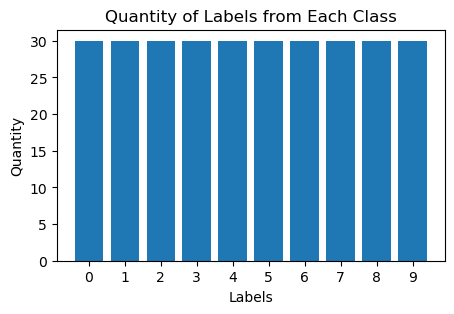

In [3]:
def draw_bar_chart(labels):
    fig, ax = plt.subplots(figsize=(5, 3))
    # Count the frequency of each label
    label_counts = Counter(labels)

    # Get the labels and their respective counts
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    # Set up the bar chart
    plt.bar(labels, counts)
    ax.set_xticks(labels)
    plt.xlabel('Labels')
    plt.ylabel('Quantity')
    plt.title('Quantity of Labels from Each Class')

    # Display the chart
    plt.show()

draw_bar_chart(y)

[0 1 2 3 4 5 6 7 8 9]
10


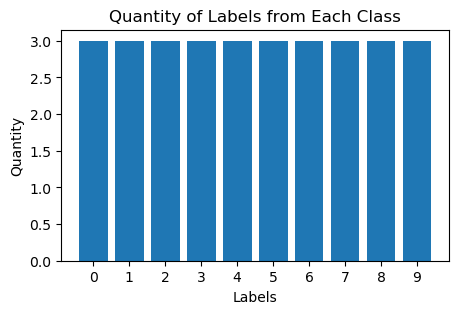

In [4]:
num = len(y)

idx = np.random.permutation(num)

x = x[idx]
y = y[idx]

x = x.reshape((x.shape[0], x.shape[1], 1))

n_classes = len(np.unique(y))

print(np.unique(y))

print(n_classes)

x_train, y_train, x_val, y_val, x_test, y_test = split_and_shuffle2(x, y)

draw_bar_chart(y_val)

In [5]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [6]:

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


In [7]:
input_shape = x.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[256],
    mlp_dropout=0,
    dropout=0.3,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["sparse_categorical_accuracy"]
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)]

results = model.fit(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    #validation_split=0.2,
    epochs=1000,
    batch_size=16,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

2023-05-15 19:14:40.260834: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-15 19:14:40.302756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-15 19:14:40.303496: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 10, 1)       2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 10, 1)       7169        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

2023-05-15 19:14:48.669107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-15 19:14:49.439106: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f5e0c3db490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-15 19:14:49.439136: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 960M, Compute Capability 5.0
2023-05-15 19:14:49.444414: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-15 19:14:49.602466: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 [==============================] - 17s 66ms/step - loss: 2.5070 - sparse_categorical_accuracy: 0.1125 - val_loss: 2.1494 - val_sparse_categorical_accuracy: 0.1667
Epoch 2/1000
15/15 [==============================] - 0s 20ms/step - loss: 2.1287 - sparse_categorical_accuracy: 0.1792 - val_loss: 1.9662 - val_sparse_categorical_accuracy: 0.2333
Epoch 3/1000
15/15 [==============================] - 0s 20ms/step - loss: 1.9374 - sparse_categorical_accuracy: 0.2542 - val_loss: 1.8897 - val_sparse_categorical_accuracy: 0.2667
Epoch 4/1000
15/15 [==============================] - 0s 20ms/step - loss: 1.7939 - sparse_categorical_accuracy: 0.2542 - val_loss: 1.8463 - val_sparse_categorical_accuracy: 0.1333
Epoch 5/1000
15/15 [==============================] - 0s 20ms/step - loss: 1.6873 - sparse_categorical_accuracy: 0.3375 - val_loss: 1.8209 - val_sparse_categorical_accuracy: 0.1333
Epoch 6/1000
15/15 [==============================] - 0s 20ms/step - loss: 1.6211 - sparse_categorical_accu

[0.15771597623825073, 0.9333333373069763]

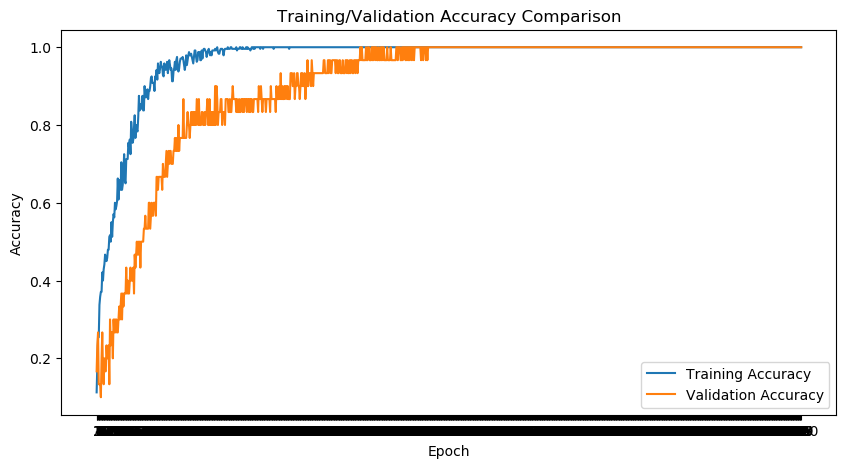

In [8]:
plot_accuracy_comparison([results.history["sparse_categorical_accuracy"], results.history["val_sparse_categorical_accuracy"]],
                        "Training/Validation Accuracy Comparison",
                        ["Training Accuracy", "Validation Accuracy"])

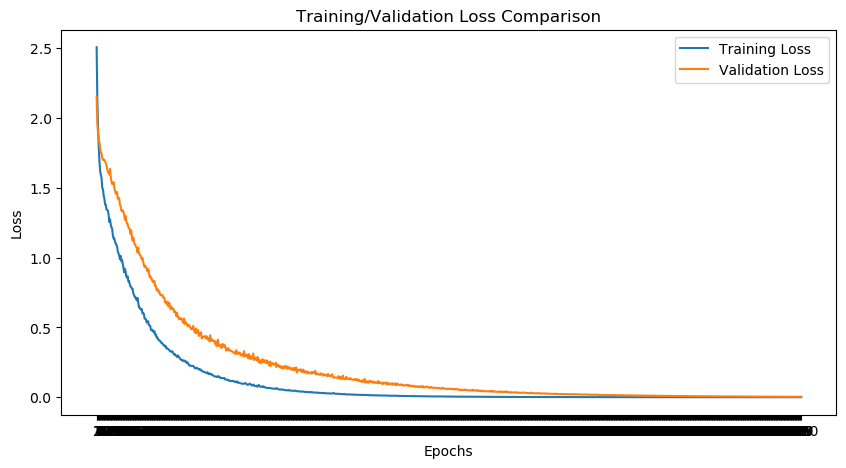

In [9]:
plot_loss_comparison([results.history["loss"], results.history["val_loss"]],
                     "Training/Validation Loss Comparison",
                     ["Training Loss", "Validation Loss"])

1/1 [==============================] - 0s 443ms/step


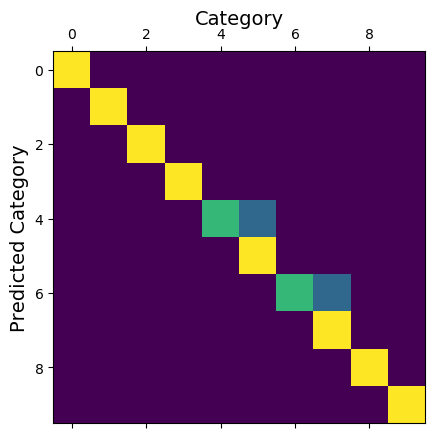

In [10]:
y_pred=np.argmax(model.predict(x_test), axis=-1)
plot_confusion_matrix(y_test, y_pred)

In [11]:
#a = np.array([0,1,0,0,1,0,0,1,0,0])
#a = np.array([1,1,0,1,1,0,1,1,0,1])
#a = np.array([2,2,0,2,2,1,2,2,3,2])
a = np.array([7,7,0,7,7,3,7,7,6,7])

a = a.reshape((1, a.shape[0],1))

print(a.shape)

model.predict(a)

(1, 10, 1)
1/1 [==============================] - 0s 68ms/step


array([[0.00000000e+00, 3.12160207e-15, 1.87114259e-04, 1.73225745e-23,
        1.24908594e-20, 3.28866405e-12, 2.20456049e-02, 9.22215939e-01,
        5.55513501e-02, 4.55502823e-12]], dtype=float32)

In [12]:
model.save('../models/transformer_numbers')

2023-05-15 19:20:20.448600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10,1]
	 [[{{node inputs}}]]
2023-05-15 19:20:20.472696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10,4]
	 [[{{node inputs}}]]
2023-05-15 19:20:20.518519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10,1]
	 [[{{node inputs}}]]
2023-05-15 19

INFO:tensorflow:Assets written to: ../models/transformer_numbers/assets


INFO:tensorflow:Assets written to: ../models/transformer_numbers/assets


In [13]:
#model = tf.keras.models.load_model('../models/transformer_numbers')